In [1]:
import math
import numpy as np
import scipy.signal as ss
import matplotlib.pyplot as plt
from scipy import stats, integrate
import pandas as pd
import pytz
import datetime as dt

import biosppy
from biosppy import storage
from biosppy.signals import ecg


# misc
import warnings
import seaborn as sns

from matplotlib.patches import Ellipse

In [2]:
#signal processing
from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz

## Fetching and making data compatible for preproceesing and visualization ----

In [3]:
def read_manipulate_psychopy(psychopy_path):
    
    psychopy_df = pd.read_csv(psychopy_path)
    col_list = [col for col in psychopy_df.columns if col.endswith('_ts')]
    col_list.insert(0, "Reference_time")
    psychopy_df_selected = psychopy_df[col_list]
    
    return psychopy_df_selected


def get_nonNan_list_psychopy(psychopy_df, col_name):
    
    
    selected_vals=[val for val in psychopy_df[col_name].to_list() if not(math.isnan(val))]
    
    return selected_vals



def get_start_stop_timestamps_psychopy(psychopy_file_path,event_interest, offset_min_list, index_interest):
    psychopy_df = read_manipulate_psychopy(psychopy_file_path)
    non_nan_timestamp=get_nonNan_list_psychopy(psychopy_df, event_interest)
    if index_interest == 0:
        start_timestamp = non_nan_timestamp[0]
        stop_timestamp = get_offset_timestamp(start_timestamp, offset_min_list[0])
        
    elif index_interest == 1:
        #start_timestamp = non_nan_timestamp[0]
        start_timestamp = get_offset_timestamp(non_nan_timestamp[0], offset_min_list[0])
        stop_timestamp = get_offset_timestamp(start_timestamp, offset_min_list[1])
            
    elif index_interest == 2:
            
        start_timestamp = get_offset_timestamp(non_nan_timestamp[0], offset_min_list[0])
        start_timestamp = get_offset_timestamp(start_timestamp, offset_min_list[1])
        stop_timestamp = get_offset_timestamp(start_timestamp, offset_min_list[2])
            
    return start_timestamp, stop_timestamp



#######---------------------------------------------------
###### ------------------Shimmer--------------------------
###----------------------------------------------------------


def read_shimmer_sensor(sensor_file_path):
    
    shimmer_df = pd.read_csv(sensor_file_path, sep='\t', low_memory=False)
    shimmer_df = shimmer_df.reset_index()
    shimmer_df.columns = shimmer_df.iloc[0]
    shimmer_df.drop([0, 1], axis=0, inplace=True)
    shimmer_df=shimmer_df.reset_index(drop=True)
    
    return shimmer_df

def standardize_timestamps_shimmer(shimmer_df, timestamps_col_name):
    
    timesstamps_list = shimmer_df[timestamps_col_name].to_list()
    new_timestamps_list = [float(val)/1000 for val in  timesstamps_list]
    
    shimmer_df[timestamps_col_name] = new_timestamps_list
    
    return shimmer_df



def get_offset_timestamp(timestamp, offset_mins):
    
    time_zone = 'Europe/Berlin'
    tz = pytz.timezone(time_zone)
    local_time = dt.datetime.fromtimestamp(timestamp, tz)
    time_change = dt.timedelta(minutes=offset_mins)
    new_time = local_time + time_change
    new_timestamp =  dt.datetime.timestamp(new_time)
    return new_timestamp

def get_list_timestamp_interest(starting_timestamp, list_offset_mins):
    
    starting_timestamp_list=[]
    
    for offset_min in list_offset_mins:
        starting_timestamp_list.append(starting_timestamp)
        timestamp_offset = get_offset_timestamp(starting_timestamp, offset_min)
        starting_timestamp = timestamp_offset  
     
    
    #starting_timestamp_list = sorted(starting_timestamp_list, key = lambda x:float(x))
    return starting_timestamp_list
        
        

def slice_df_wrt_timestamps(df, start_timestamp, end_timestamp, timestamps_col):
    
    sliced_df=df[(df[timestamps_col]>= start_timestamp) & (df[timestamps_col] <= end_timestamp)]
    
    return sliced_df


def from_str_to_float(str_list):
    
    float_array =[float(val) for val in str_list]
    
    return float_array

def col_from_str_float (df, col_name):
    
    str_list = df[col_name].values
    
    float_array =[float(val) for val in str_list]
    
    df[col_name] = float_array
    
    return df

## Preprocessing the raw data: Filtering, IBI extraction 

In [4]:
def detect_peaks(ecg_signal, threshold=0.3, qrs_filter=None):
    '''
    Peak detection algorithm using cross corrrelation and threshold 
    '''
    if qrs_filter is None:
        # create default qrs filter, which is just a part of the sine function
        t = np.linspace(1.5 * np.pi, 3.5 * np.pi, 15)
        qrs_filter = np.sin(t)
    
    # normalize data
    ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

    # calculate cross correlation
    similarity = np.correlate(ecg_signal, qrs_filter, mode="same")
    similarity = similarity / np.max(similarity)

    # return peaks (values in ms) using threshold
    return ecg_signal[similarity > threshold].index, similarity



def group_peaks(p, threshold=5):
    '''
    The peak detection algorithm finds multiple peaks for each QRS complex. 
    Here we group collections of peaks that are very near (within threshold) and we take the median index 
    '''
    # initialize output
    output = np.empty(0)

    # label groups of sample that belong to the same peak
    peak_groups, num_groups = label(np.diff(p) < threshold)

    # iterate through groups and take the mean as peak index
    for i in np.unique(peak_groups)[1:]:
        peak_group = p[np.where(peak_groups == i)]
        output = np.append(output, int(np.median(peak_group)))
        
        
    #output = int(output)
    return output

def from_rr_ind_2_msec(r_peaks_ind, sampling_freq = 256):
    
    # RR-intervals are the differences between successive peaks
    r_peaks_sec = r_peaks_ind*1/sampling_freq
    r_peaks_msec = r_peaks_sec*1000

    r_peaks_diff_msec=np.diff(r_peaks_msec)
    
    return r_peaks_diff_msec
    

def remove_outliers_rri(r_peaks_diff_msec, sampling_freq = 256, outlier_std = 2):
    
    # RR-intervals are the differences between successive peaks
    #r_peaks_sec = r_peaks*1/sampling_freq
    #r_peaks_msec = r_peaks_sec*1000

    #r_peaks_diff=np.diff(r_peaks_msec)
    
    rr_corrected = r_peaks_diff_msec.copy()

    rr_corrected[np.abs(zscore(r_peaks_diff_msec)) > outlier_std] = np.median(r_peaks_diff_msec)
    
    return rr_corrected
    


## Plot raw and filtered ECG data with r-r interval ECG data  

In [5]:
def get_plot_ranges(start=10, end=20, n=5):
    '''
    Make an iterator that divides into n or n+1 ranges. 
    - if end-start is divisible by steps, return n ranges
    - if end-start is not divisible by steps, return n+1 ranges, where the last range is smaller and ends at n
    
    # Example:
    >> list(get_plot_ranges())
    >> [(0.0, 3.0), (3.0, 6.0), (6.0, 9.0)]

    '''
    distance = end - start
    for i in np.arange(start, end, np.floor(distance/n)):
        yield (int(i), int(np.minimum(end, np.floor(distance/n) + i)))

def plot_ecg_wf(sliced_ecg_df,r_peaks,time_offset, raw_data_col_name="raw_ecg", filtered_data_col_name="filtered", nr_plots=3):    
    
    starting_index_slcide_df= sliced_ecg_df.index[0]
    sampfrom = starting_index_slcide_df
    sampto = starting_index_slcide_df+256*time_offset*60
    
    rr_interval_cumm = []
    for start, stop in get_plot_ranges(sampfrom, sampto, nr_plots):
        print(start)
        print(stop)
        # get sliced data of ECG
        #cond_slice = (sliced_ecg_df.index>= start) & (sliced_ecg_df.index <= stop)
        #sliced_ecg_hrv =sliced_ecg_df.filtered[cond_slice]
        
        sliced_ecg_filtered = sliced_ecg_df[filtered_data_col_name][(sliced_ecg_df.index >= start) & (sliced_ecg_df.index<= stop)]
        
        sliced_ecg_raw = sliced_ecg_df[raw_data_col_name][(sliced_ecg_df.index >= start) & (sliced_ecg_df.index<= stop)]
        
        
        r_peaks_selected = [r_p for r_p in r_peaks if r_p >= start and r_p <= stop]
        
        plt.figure(figsize=(20, 15))

        plt.subplot(211)
        plt.title("Raw ECG", fontsize=24)
        plt.plot(sliced_ecg_raw, label="ECG", color="#51A6D8", linewidth=2)
        #plt.plot(sliced_ecg_hrv.index[start: stop], sliced_ecg_hrv, label="ECG", color="#51A6D8", linewidth=1)
        #plt.plot(r_peaks_selected, np.repeat(0.3, len(r_peaks_selected)), label="peaks", color="orange", marker="o", linestyle="None")
        plt.legend(loc="upper right", fontsize=16)
        plt.xlabel("Time (milliseconds)", fontsize=18)
        plt.ylabel("Amplitude (arbitrary unit)", fontsize=18)
        plt.tick_params(axis='both', which='major', labelsize=18)

        plt.subplot(212)
        plt.title('Filtered ECG', fontsize=24)
        
        #plt.plot(ecg_slice.index, similarity, label="Similarity with QRS filter", color="olive", linewidth=1)
        plt.plot(sliced_ecg_filtered, label="Filtered ECG", color="olive", linewidth=2)
        plt.plot(r_peaks_selected, np.repeat(0.4, len(r_peaks_selected)), label="peaks", color="orange", marker="o", linestyle="None",  markersize=10)
        plt.tick_params(axis='both', which='major', labelsize=18)
        plt.legend(loc="upper right", fontsize=16)
        plt.xlabel("Time (milliseconds)", fontsize=18)
        plt.ylabel("Similarity (normalized)", fontsize=18)
        plt.tick_params(axis='both', which='major', labelsize=18)

## Plot rr-intervals

In [6]:
def plot_rr_intervals(rr_msec):
    
    plt.figure(figsize=(20, 7))
    font_size = 18
    font_size_title = 24
    plt.title("RR-intervals", fontsize=font_size_title)
    plt.xlabel("Time (ms)", fontsize=font_size)
    plt.ylabel("RR-interval (ms)", fontsize = font_size)
    plt.plot(np.cumsum(rr_msec), rr_msec, label="RR-interval", color="#A651D8")
    plt.tick_params(axis='both', which='major', labelsize=font_size)
    plt.ylim(0,1800)
    plt.show()
    #print(r_peaks_msec)
    
    
def plot_rr_rr_interpolated_intervals(rr_msec, rr_msec_interpolated, fs=4):
    font_size = 18
    font_size_title = 24
    
    x_rr = np.cumsum(rr_msec)/1200
    steps =1/fs
    xx_rr_inter = np.arange(0, np.max(x_rr-1), steps)
    plt.figure(figsize=(20, 15))

    plt.subplot(211)
    plt.title("RR intervals",  fontsize=font_size_title)
    plt.plot(x_rr, rr_msec, color="k", markerfacecolor="#A651D8", markeredgewidth=0, marker="o", markersize=8)
    plt.xlabel("Time (s)", fontsize=font_size)
    plt.ylabel("RR-interval (ms)", fontsize=font_size)
    #plt.title("RR-Intrevals", fontsize=font_size_title)
    plt.tick_params(axis='both', which='major', labelsize=font_size)
    plt.gca().set_xlim(0, 350)

    plt.subplot(212)
    plt.title("RR-Intervals (cubic interpolation)", fontsize=font_size_title)
    plt.plot(xx_rr_inter, rr_msec_interpolated, color="k", markerfacecolor="#51A6D8", markeredgewidth=0, marker="o", markersize=8)
    plt.gca().set_xlim(0, 350)
    plt.xlabel("Time (s)",  fontsize=font_size)
    plt.ylabel("RR-interval (ms)",  fontsize=font_size)
    plt.tick_params(axis='both', which='major', labelsize=font_size)
    plt.show()

In [7]:
def plot_rr_inerval_distribution(rr_msec):
    
    plt.figure()
    plt.figure(figsize=(20, 7))
    font_size = 18
    font_size_title = 24
    
    plt.title("Distribution of RR-intervals", fontsize=font_size_title)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore") # ignore FutureWarning 
        sns.kdeplot(rr_msec, label="rr-intervals", color="#A651D8", shade=True)


    outlier_low = np.mean(rr_msec) - 1 * np.std(rr_msec)
    outlier_high = np.mean(rr_msec) + 1 * np.std(rr_msec)
    plt.axvline(x=outlier_low, color= "green")
    plt.axvline(x=outlier_high, color= "green")

    plt.axvline(x=np.mean(rr_msec))
    #plt.text(outlier_low - 370, 0.004, "outliers low (< mean - 2 sigma)")
    #plt.text(outlier_high + 20, 0.004, "outliers high (> mean + 2 sigma)")

    plt.xlabel("RR-interval (ms)", fontsize=font_size)
    plt.ylabel("Density", fontsize=font_size)
    plt.tick_params(axis='both', which='major', labelsize=font_size)

    plt.legend()
    plt.show()

In [8]:
def plot_poincare(rr):
    
    font_size = 18
    font_size_title = 24
    
    rr_n = rr[:-1]
    rr_n1 = rr[1:]

    sd1 = np.sqrt(0.5) * np.std(rr_n1 - rr_n)
    sd2 = np.sqrt(0.5) * np.std(rr_n1 + rr_n)

    m = np.mean(rr)
    min_rr = np.min(rr)
    max_rr = np.max(rr)
    
    plt.figure(figsize=(10, 10))
    plt.title("Poincare plot", fontsize=font_size_title)

    sns.scatterplot(x=rr_n, y=rr_n1, color="#51A6D8")

    plt.xlabel(r'$RR_n (ms)$', fontsize=font_size)
    plt.ylabel(r'$RR_{n+1} (ms)$', fontsize=font_size)

    e1 = Ellipse((m, m), 2*sd1, 2*sd2, angle=-45, linewidth=1.2, fill=False, color="k")
    plt.gca().add_patch(e1)

    plt.arrow(m, m, (max_rr-min_rr)*0.4, (max_rr-min_rr)*0.4, color="k", linewidth=0.8, head_width=5, head_length=5)
    plt.arrow(m, m, (min_rr-max_rr)*0.4, (max_rr-min_rr)*0.4, color="k", linewidth=0.8, head_width=5, head_length=5)

    plt.arrow(m, m, sd2 * np.sqrt(0.5), sd2 * np.sqrt(0.5), color="green", linewidth=5)
    plt.arrow(m, m, -sd1 * np.sqrt(0.5), sd1 * np.sqrt(0.5), color="red", linewidth=5)

    plt.text(max_rr, max_rr, "SD2", fontsize=20, color="green")
    plt.text(m-(max_rr-min_rr)*0.4-20, max_rr, "SD1", fontsize=20, color="red")
    plt.tick_params(axis='both', which='major', labelsize=font_size)
    return sd1, sd2




### Extract time domain features from RR interval

In [9]:
def timedomain(rr):
    results = {}

    hr = 60000/rr
    
    results['Mean RR (ms)'] = np.mean(rr)
    results['STD RR/SDNN (ms)'] = np.std(rr)
    results['Mean HR (beats/min)'] = np.mean(hr)
    results['STD HR (beats/min)'] = np.std(hr)
    results['Min HR (beats/min)'] = np.min(hr)
    results['Max HR (beats/min)'] = np.max(hr)
    results['RMSSD (ms)'] = np.sqrt(np.mean(np.square(np.diff(rr))))
    results['NNxx'] = np.sum(np.abs(np.diff(rr)) > 50)*1
    results['pNNxx (%)'] = 100 * np.sum((np.abs(np.diff(rr)) > 50)*1) / len(rr)
    return results

## To get fix number of samples in each seconds :  from rr to rr interpolated 

In [10]:
def from_rr_to_rr_interpolated(rr_msec, fs = 4):
    #create interpolation function based on the r-r samples
    
    # sample in seconds(x-axis)
    x = np.cumsum(rr_msec)/1400 
    f = interp1d(x, rr_msec, kind='cubic')
    
    steps = 1/fs
    
    # now we can sample from interpolation function
    xx = np.arange(1, np.max(x), steps)
    rr_interpolated_msec = f(xx)
    
    return rr_interpolated_msec

## Power distribution in differnt frequecy ranges


In [11]:
def frequency_domain_rr(rri, fs=4):
    # rri: rr interpolated
    # Estimate the spectral density using Welch's method
    fxx, pxx = signal.welch(x=rri, fs=fs)
    
    '''
    Segement found frequencies in the bands 
     - Very Low Frequency (VLF): 0-0.04Hz 
     - Low Frequency (LF): 0.04-0.15Hz 
     - High Frequency (HF): 0.15-0.4Hz
    '''
    cond_vlf = (fxx >= 0) & (fxx < 0.04)
    cond_lf = (fxx >= 0.04) & (fxx < 0.15)
    cond_hf = (fxx >= 0.15) & (fxx < 0.4)
    
    # calculate power in each band by integrating the spectral density 
    vlf = trapz(pxx[cond_vlf], fxx[cond_vlf])
    lf = trapz(pxx[cond_lf], fxx[cond_lf])
    hf = trapz(pxx[cond_hf], fxx[cond_hf])
    
    # sum these up to get total power
    total_power = vlf + lf + hf

    # find which frequency has the most power in each band
    peak_vlf = fxx[cond_vlf][np.argmax(pxx[cond_vlf])]
    peak_lf = fxx[cond_lf][np.argmax(pxx[cond_lf])]
    peak_hf = fxx[cond_hf][np.argmax(pxx[cond_hf])]

    # fraction of lf and hf
    lf_nu = 100 * lf / (lf + hf)
    hf_nu = 100 * hf / (lf + hf)
    
    results = {}
    results['Power VLF (ms2)'] = vlf
    results['Power LF (ms2)'] = lf
    results['Power HF (ms2)'] = hf   
    results['Power Total (ms2)'] = total_power

    results['LF/HF'] = (lf/hf)
    results['Peak VLF (Hz)'] = peak_vlf
    results['Peak LF (Hz)'] = peak_lf
    results['Peak HF (Hz)'] = peak_hf

    results['Fraction LF (nu)'] = lf_nu
    results['Fraction HF (nu)'] = hf_nu
    return results, fxx, pxx

## Plot Welch's Periodogram

In [12]:
def plot_fft_spectrum(rr_msec_interpolated):
    font_size = 18
    font_size_title = 24
    
    results, fxx, pxx = frequency_domain_rr(rr_msec_interpolated)
    plt.figure(figsize=(20, 7))
    plt.plot(fxx, pxx, color="k", linewidth=0.3)
    plt.title("FFT Spectrum (Welch's periodogram)", fontsize=font_size_title)

    # create interpolation function for plotting frequency bands
    psd_f = interp1d(fxx, pxx)

    # setup frequency bands for plotting
    x_vlf = np.linspace(0, 0.04, 100)
    x_lf = np.linspace(0.04, 0.15, 100)
    x_hf = np.linspace(0.15, 0.4, 100)

    plt.gca().fill_between(x_vlf, psd_f(x_vlf), alpha=0.2, color="#A651D8", label="VLF")
    plt.gca().fill_between(x_lf, psd_f(x_lf), alpha=0.2, color="#51A6D8", label="LF")
    plt.gca().fill_between(x_hf, psd_f(x_hf), alpha=0.2, color="#D8A651", label="HF")

    plt.gca().set_xlim(0, 0.5)
    plt.gca().set_ylim(0)
    plt.xlabel("Frequency (Hz)", fontsize=font_size)
    plt.ylabel("Density", fontsize=font_size)
    plt.legend(fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=font_size)
    plt.show()


### Get raw ECG array and filtered array from the recorded data

In [15]:
#psychopy_file_path = "/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP027_271123/Psychopy_data/VP027_271123_DigiRelax_Experiment_2023-11-27_15h58.18.227.csv"
#ecg_file_path = "/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP027_271123/Shimmer_data/2023-11-27_15.21.59_VP027_271123_SD_Session1/VP027_271123_Session1_Shimmer_6B1E_Calibrated_SD.csv"

psychopy_file_path = "/media/muhammad/d5e4618d-a960-4f0d-a521-1c804bbebbb4/data_sony_digiRelax/wp3/VP007_091123/Psychopy_data/VP007_091123_DigiRelax_Experiment_2023-11-09_14h19.56.411.csv"
ecg_file_path ="/media/muhammad/d5e4618d-a960-4f0d-a521-1c804bbebbb4/data_sony_digiRelax/wp3/VP007_091123/Shimmer_data/2023-11-09_12.38.31_VP007_091123_SD_Session1/VP007_091123_Session1_Shimmer_6B1E_Calibrated_SD.csv" 

####-----------------------------------------------------------------

#psychopy_file_path = "D:/Datasets/data_sony_digiRelax/study/VP010_131123/Psychopy_data/VP010_131123_DigiRelax_Experiment_2023-11-13_09h54.08.913.csv"
#ecg_file_path ="D:/Datasets/data_sony_digiRelax/study/VP010_131123/Shimmer_data/2023-11-13_08.20.20_VP010_131123_SD_Session1/VP010_131123_Session1_Shimmer_6B1E_Calibrated_SD.csv" 

### Experiment related data
event_interest_list_new = ["baseline_instruction_ts", "tsst_prep_ts", "tsst_pres_ts", "relaxation_prep_ts"]
offset_min_list_new  = [[3], [5], [5,5], [5, 5, 5]]

ind_event_interest = 0
ind_offset_min = 0
#selected events
event_interest = event_interest_list_new[ind_event_interest]
offset_min_sublist = offset_min_list_new[ind_event_interest]
#offset time in mins

#time_offset = 3

sampling_freq = 256



In [16]:
ecg_col_name = "Shimmer_6B1E_ECG_LA-RA_24BIT_CAL"
timestamp_shimmer_col_name = "Shimmer_6B1E_Timestamp_Unix_CAL"


psychopy_df = read_manipulate_psychopy(psychopy_file_path)
non_nan_timestamp=get_nonNan_list_psychopy(psychopy_df, event_interest)

start_timestamp, stop_timestamp = get_start_stop_timestamps_psychopy(psychopy_file_path, event_interest, offset_min_sublist, ind_offset_min)

#start_timestamp = non_nan_timestamp[0]
#stop_timestamp = get_offset_timestamp(start_timestamp, time_offset)


#print("psychopy start timestamp: " + str(start_timestamp))
#print("psychopy stop timestamp: " + str(stop_timestamp))

time_zone = 'Europe/Berlin'
tz = pytz.timezone(time_zone)
    
start_time = dt.datetime.fromtimestamp(start_timestamp, tz)
end_time  = dt.datetime.fromtimestamp(stop_timestamp, tz)

print("psychopy start time: "+str(start_time))
print("psychopy stop time: "+str(end_time))

###---------ECG------------------------------------
ecg_df = read_shimmer_sensor(ecg_file_path)

selected_ecg_df = ecg_df[[timestamp_shimmer_col_name, ecg_col_name]]
selected_ecg_df = selected_ecg_df.copy()
selected_ecg_df=standardize_timestamps_shimmer(selected_ecg_df, timestamp_shimmer_col_name)


sliced_ecg_df=slice_df_wrt_timestamps(selected_ecg_df, start_timestamp, stop_timestamp, timestamp_shimmer_col_name)
sliced_ecg_df=sliced_ecg_df.reset_index(drop=True)

start_time_hr = sliced_ecg_df[timestamp_shimmer_col_name].values[0]
stop_time_hr = sliced_ecg_df[timestamp_shimmer_col_name].values[-1]

start_time_hr = dt.datetime.fromtimestamp(start_time_hr, tz)
end_time_hr  = dt.datetime.fromtimestamp(stop_time_hr, tz)

print("ECG start time: " + str(start_time_hr))
print("ECG stop time: " + str(end_time_hr))

sliced_ecg_df=sliced_ecg_df.copy()
sliced_ecg_df['heartrate'] = sliced_ecg_df[ecg_col_name]
sliced_ecg_df=col_from_str_float (sliced_ecg_df, "heartrate")

psychopy start time: 2023-11-09 14:20:35.541608+01:00
psychopy stop time: 2023-11-09 14:23:35.541608+01:00
ECG start time: 2023-11-09 14:20:35.544556+01:00
ECG stop time: 2023-11-09 14:23:35.540649+01:00


## Plot Raw ECG and filtered ecg with detected rr intervals

0
6582
6582
13164
13164
19746
19746
26328
26328
32910
32910
39492
39492
46074
46074
46080


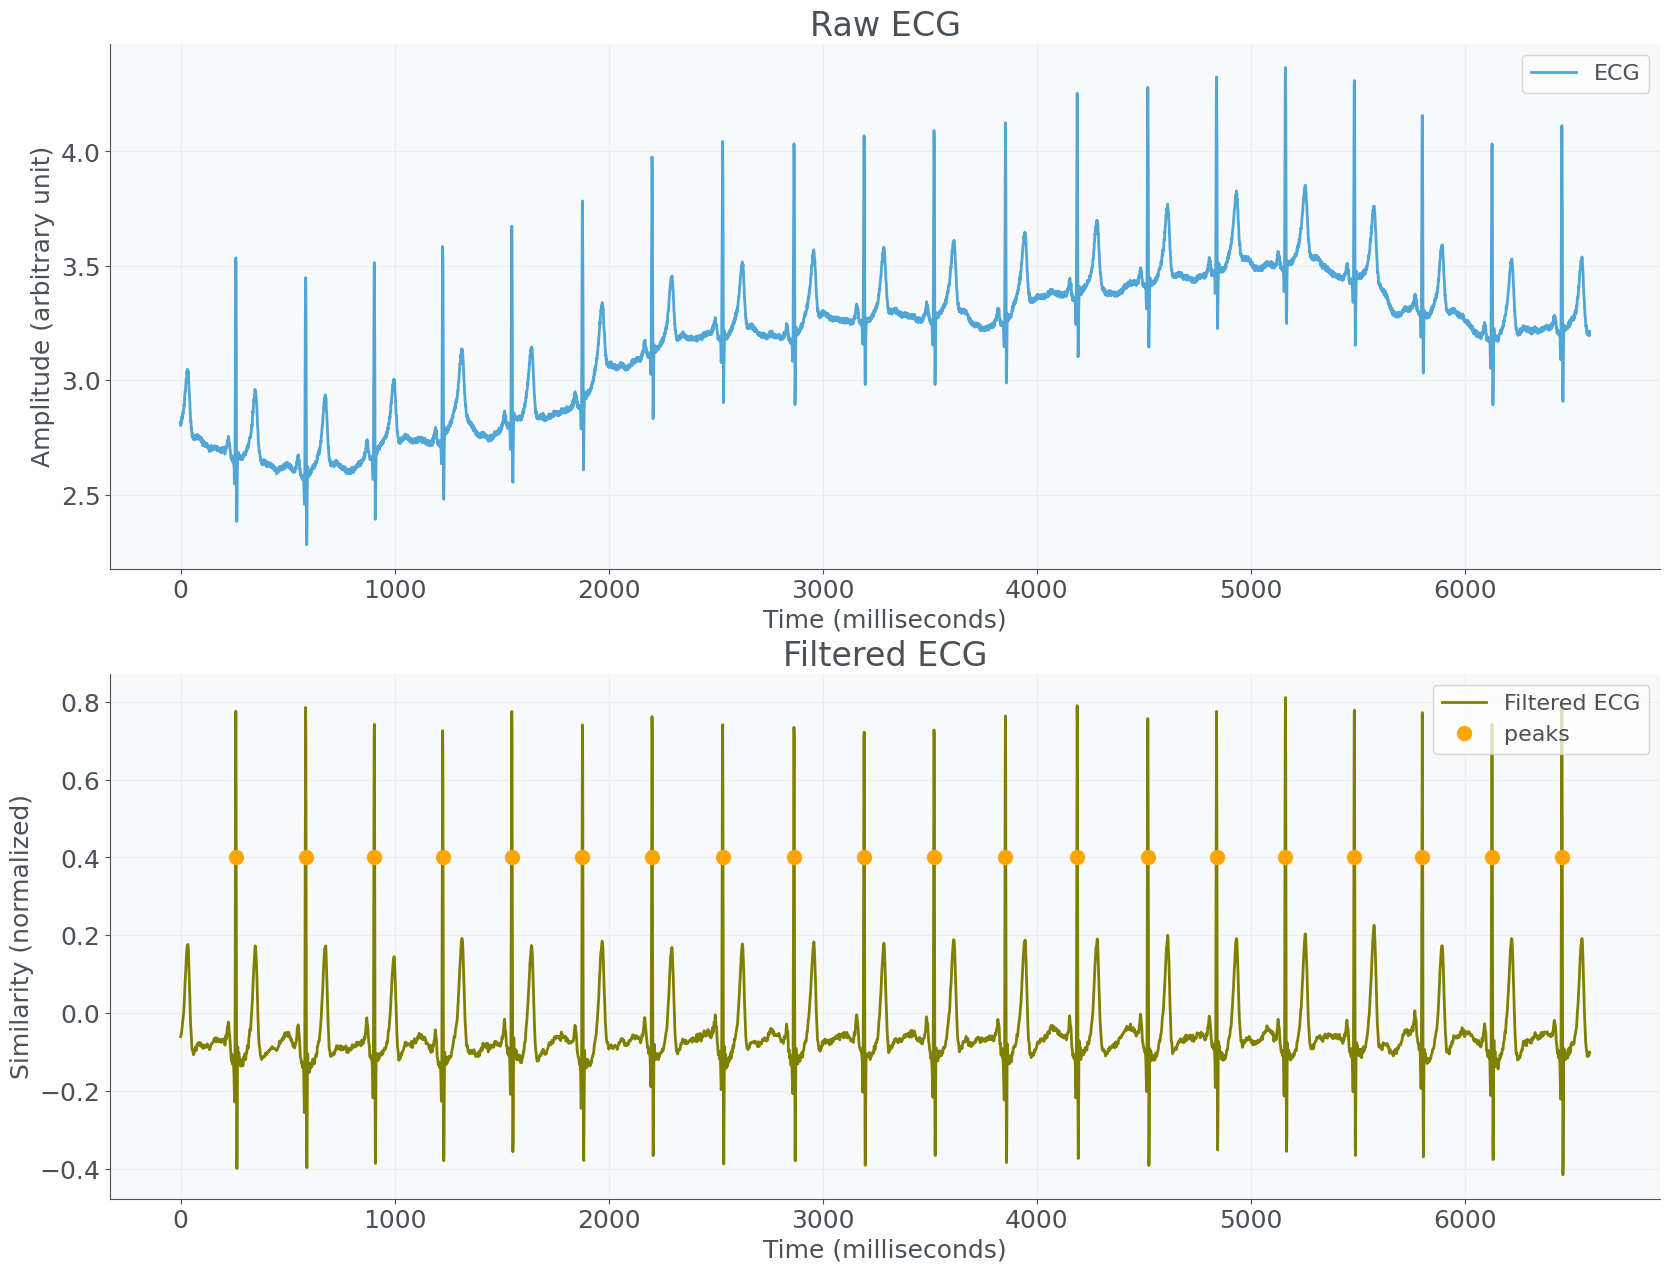

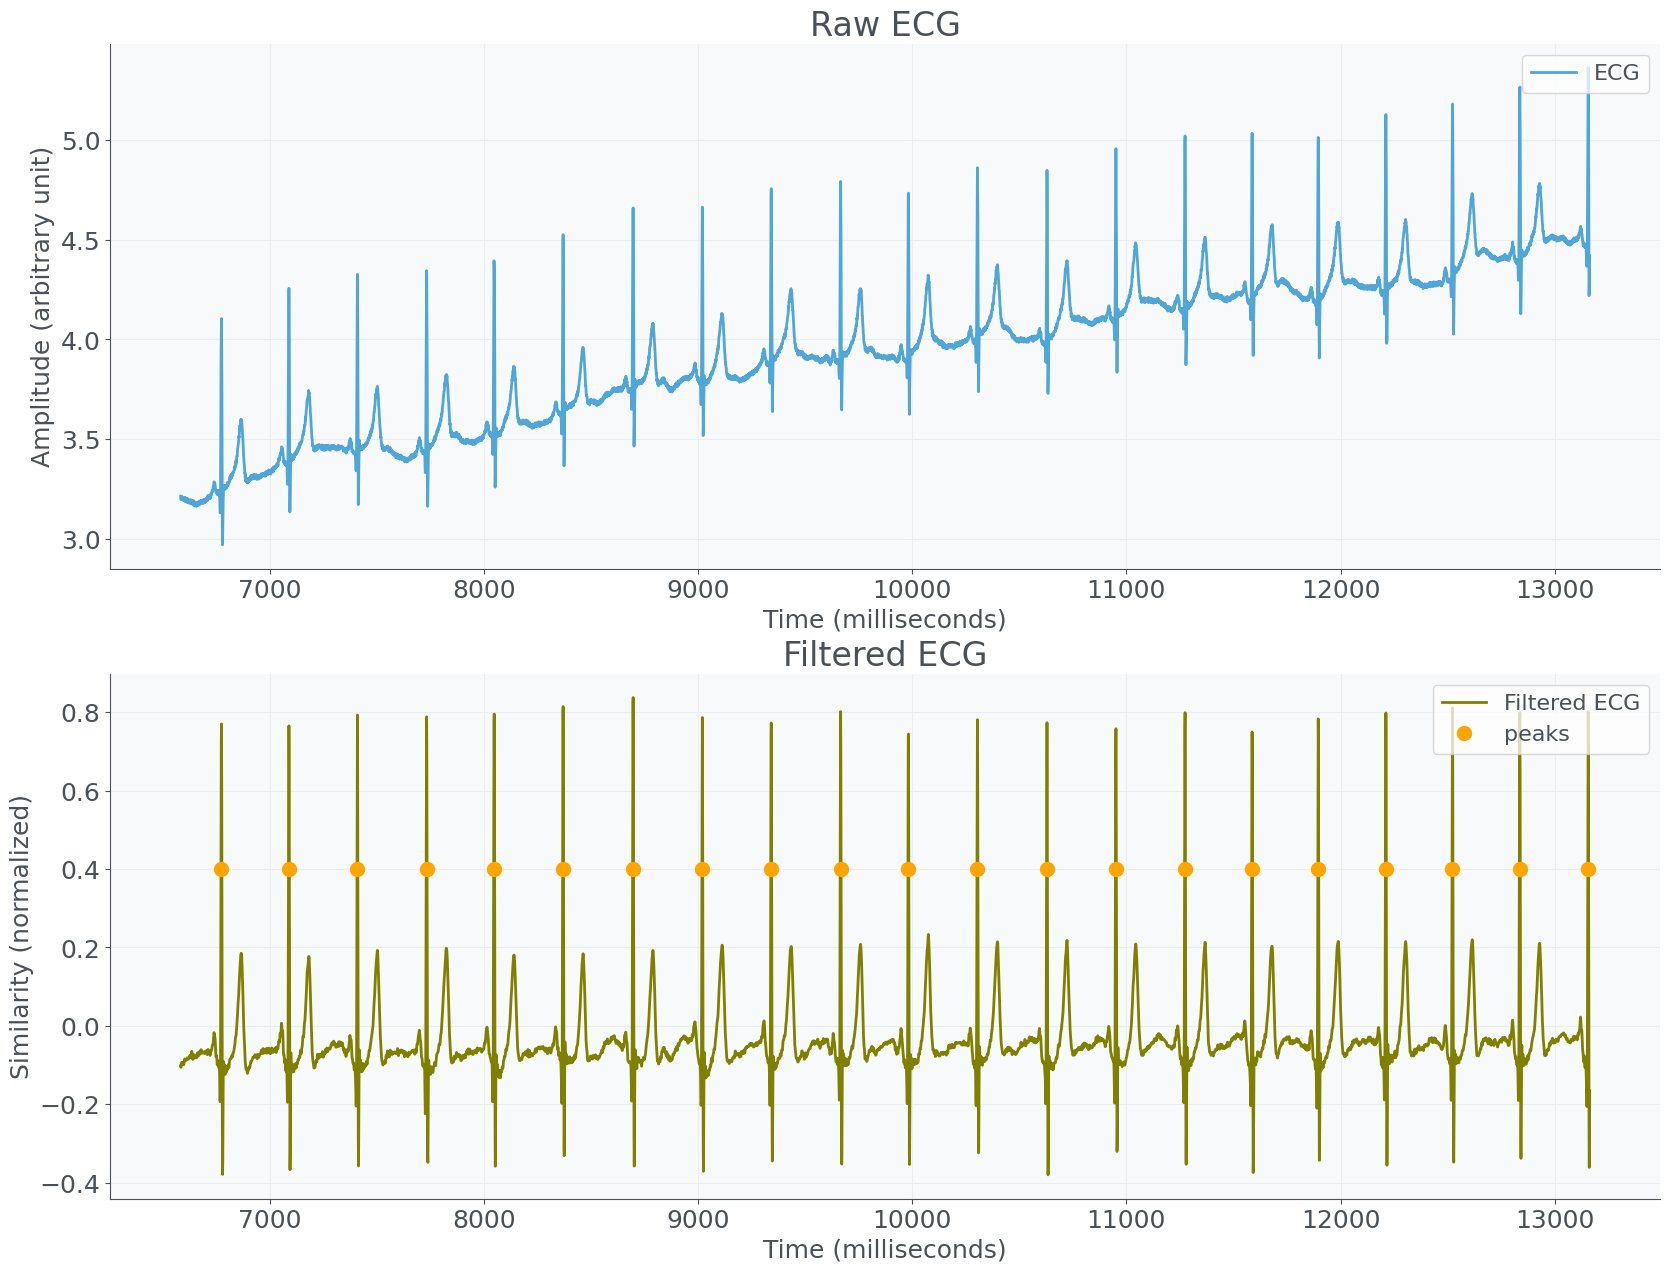

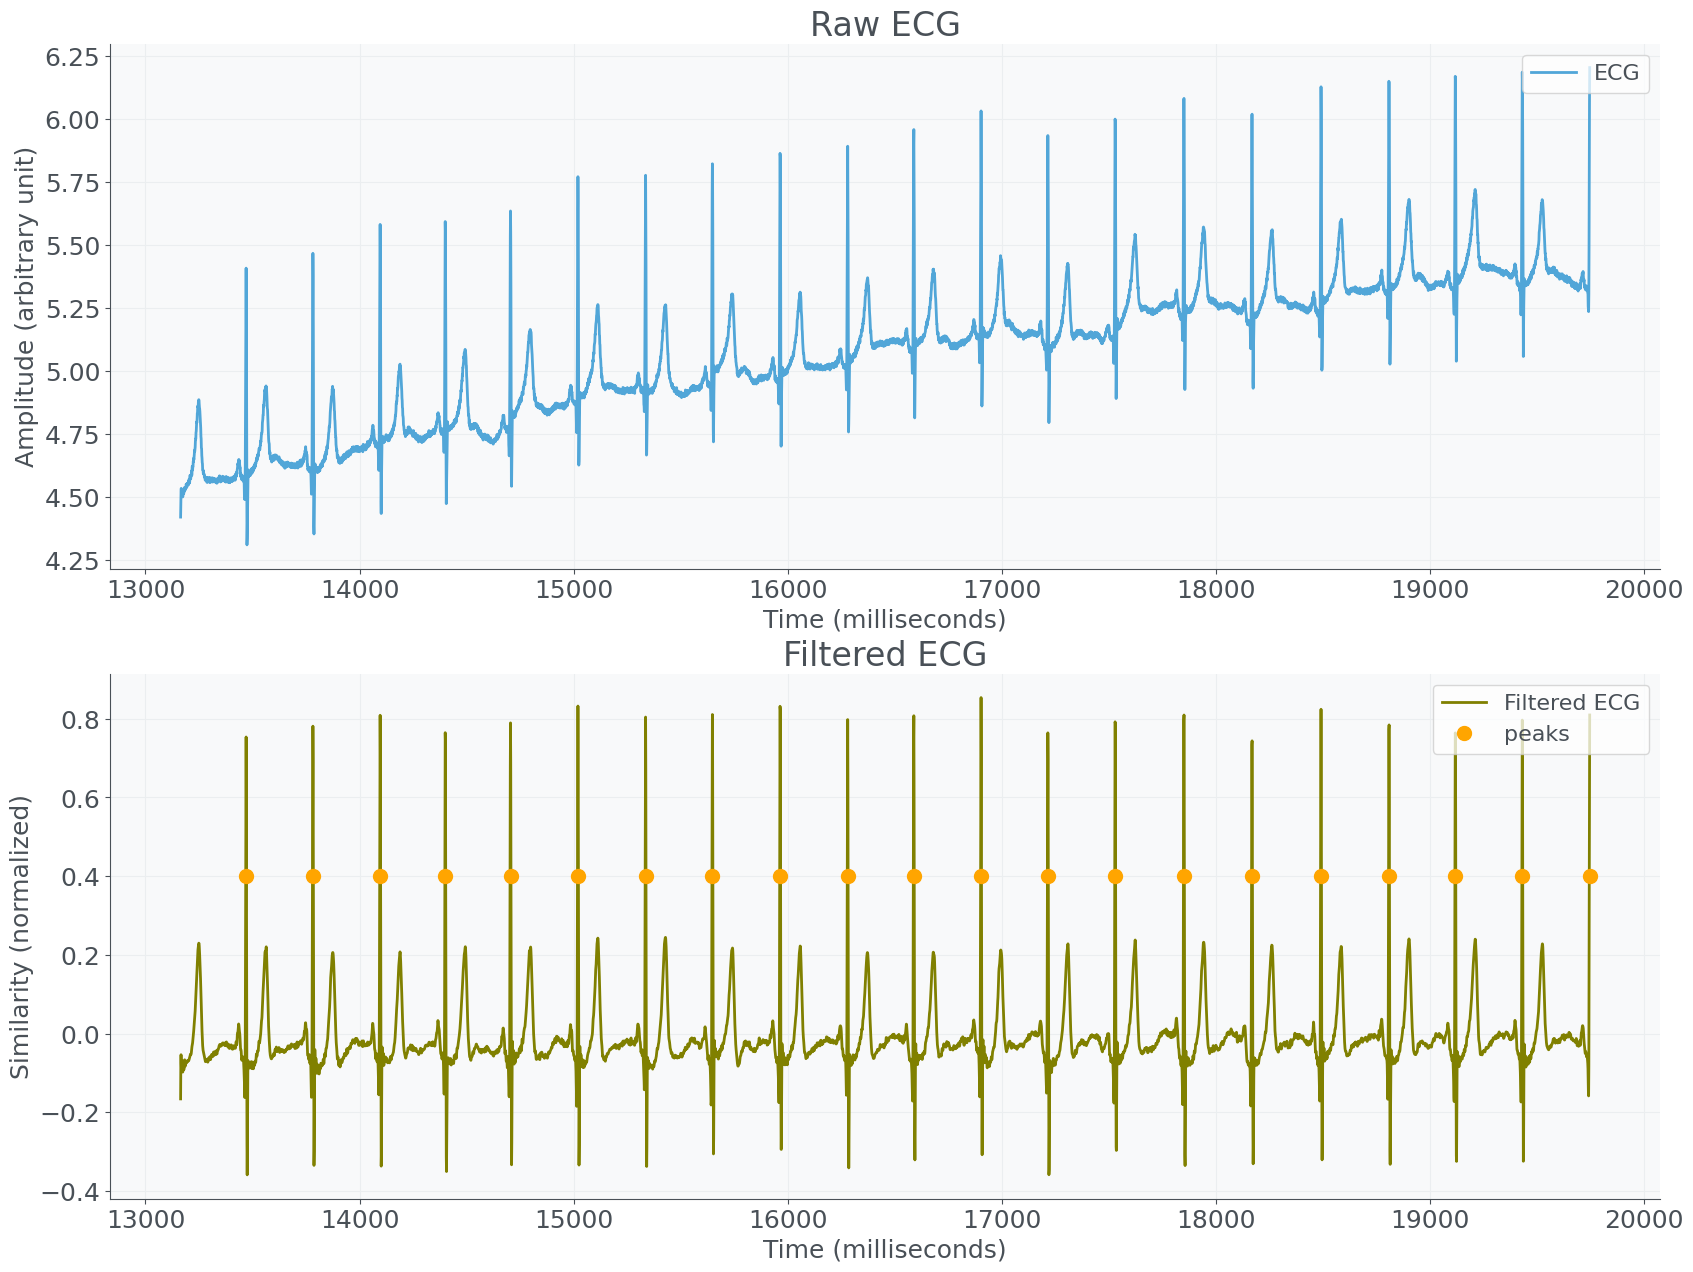

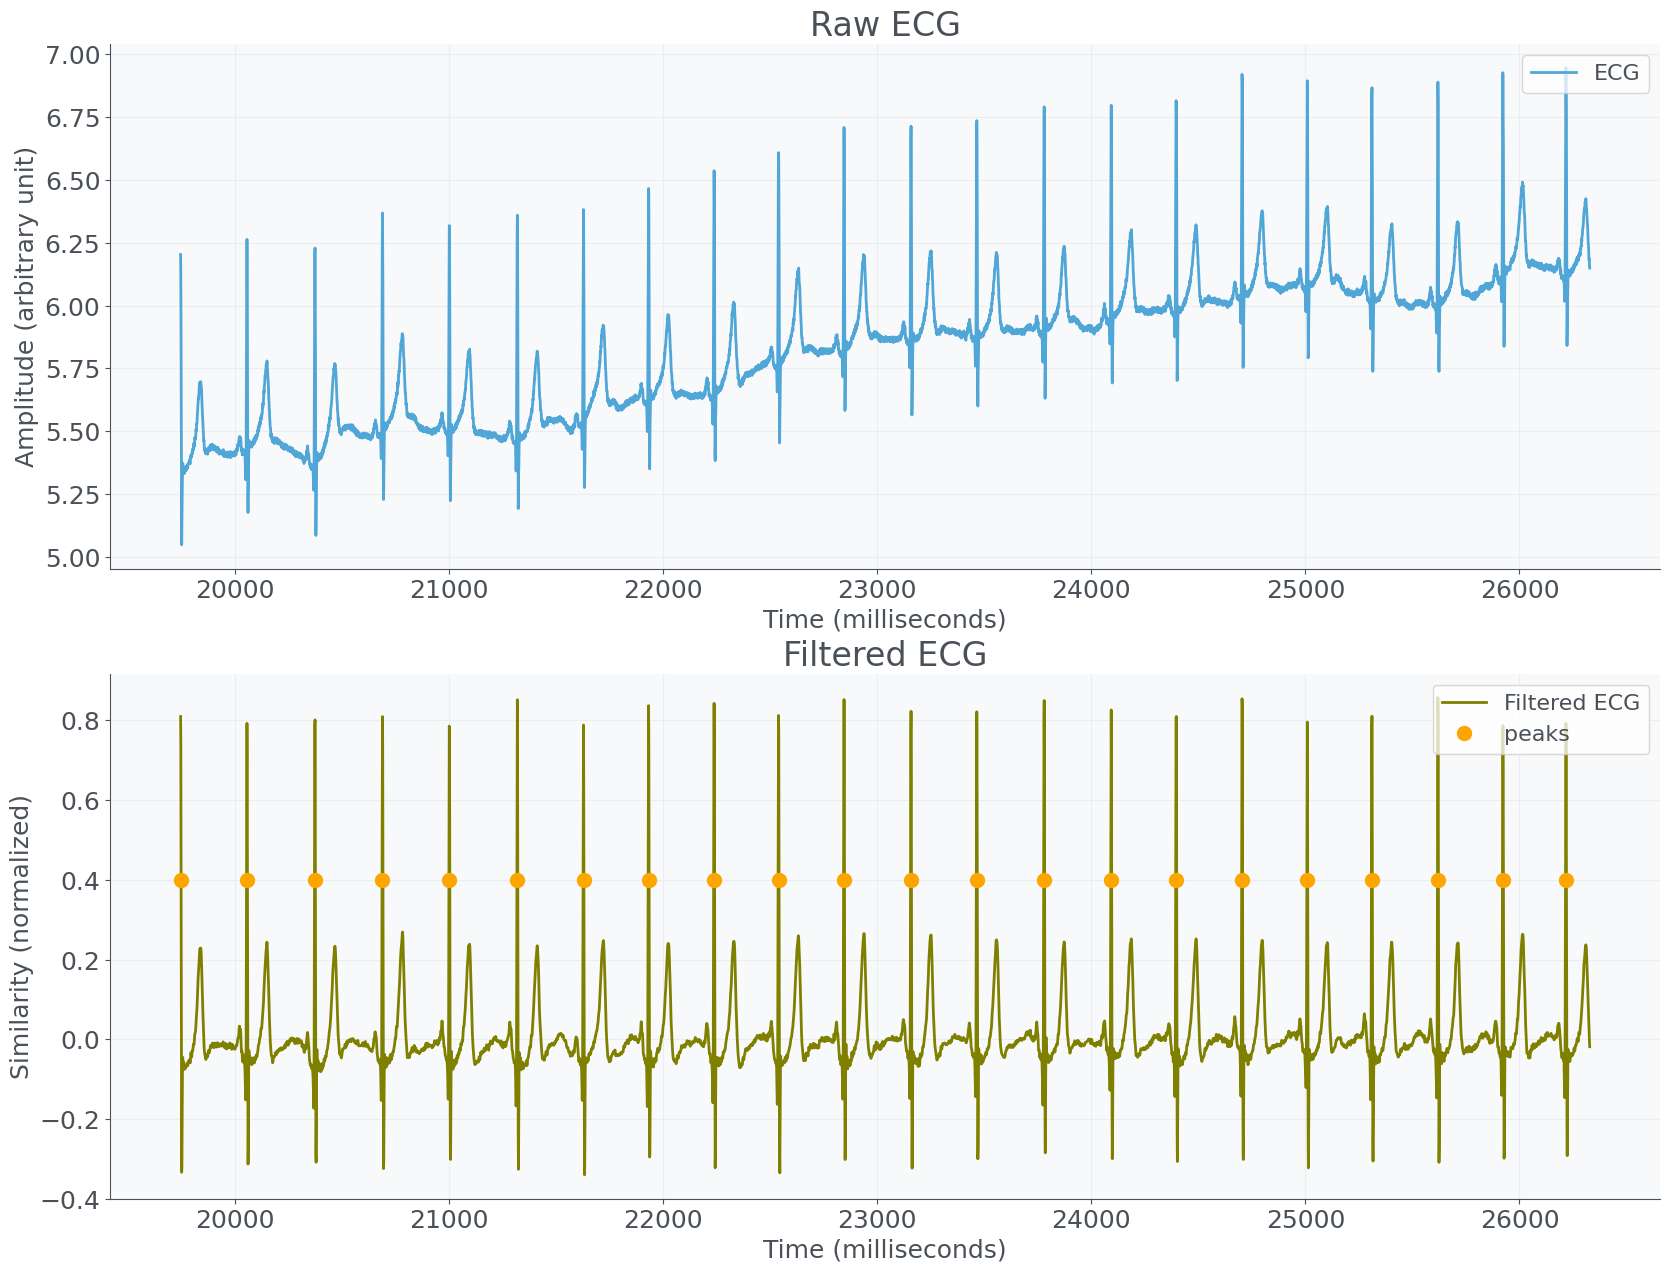

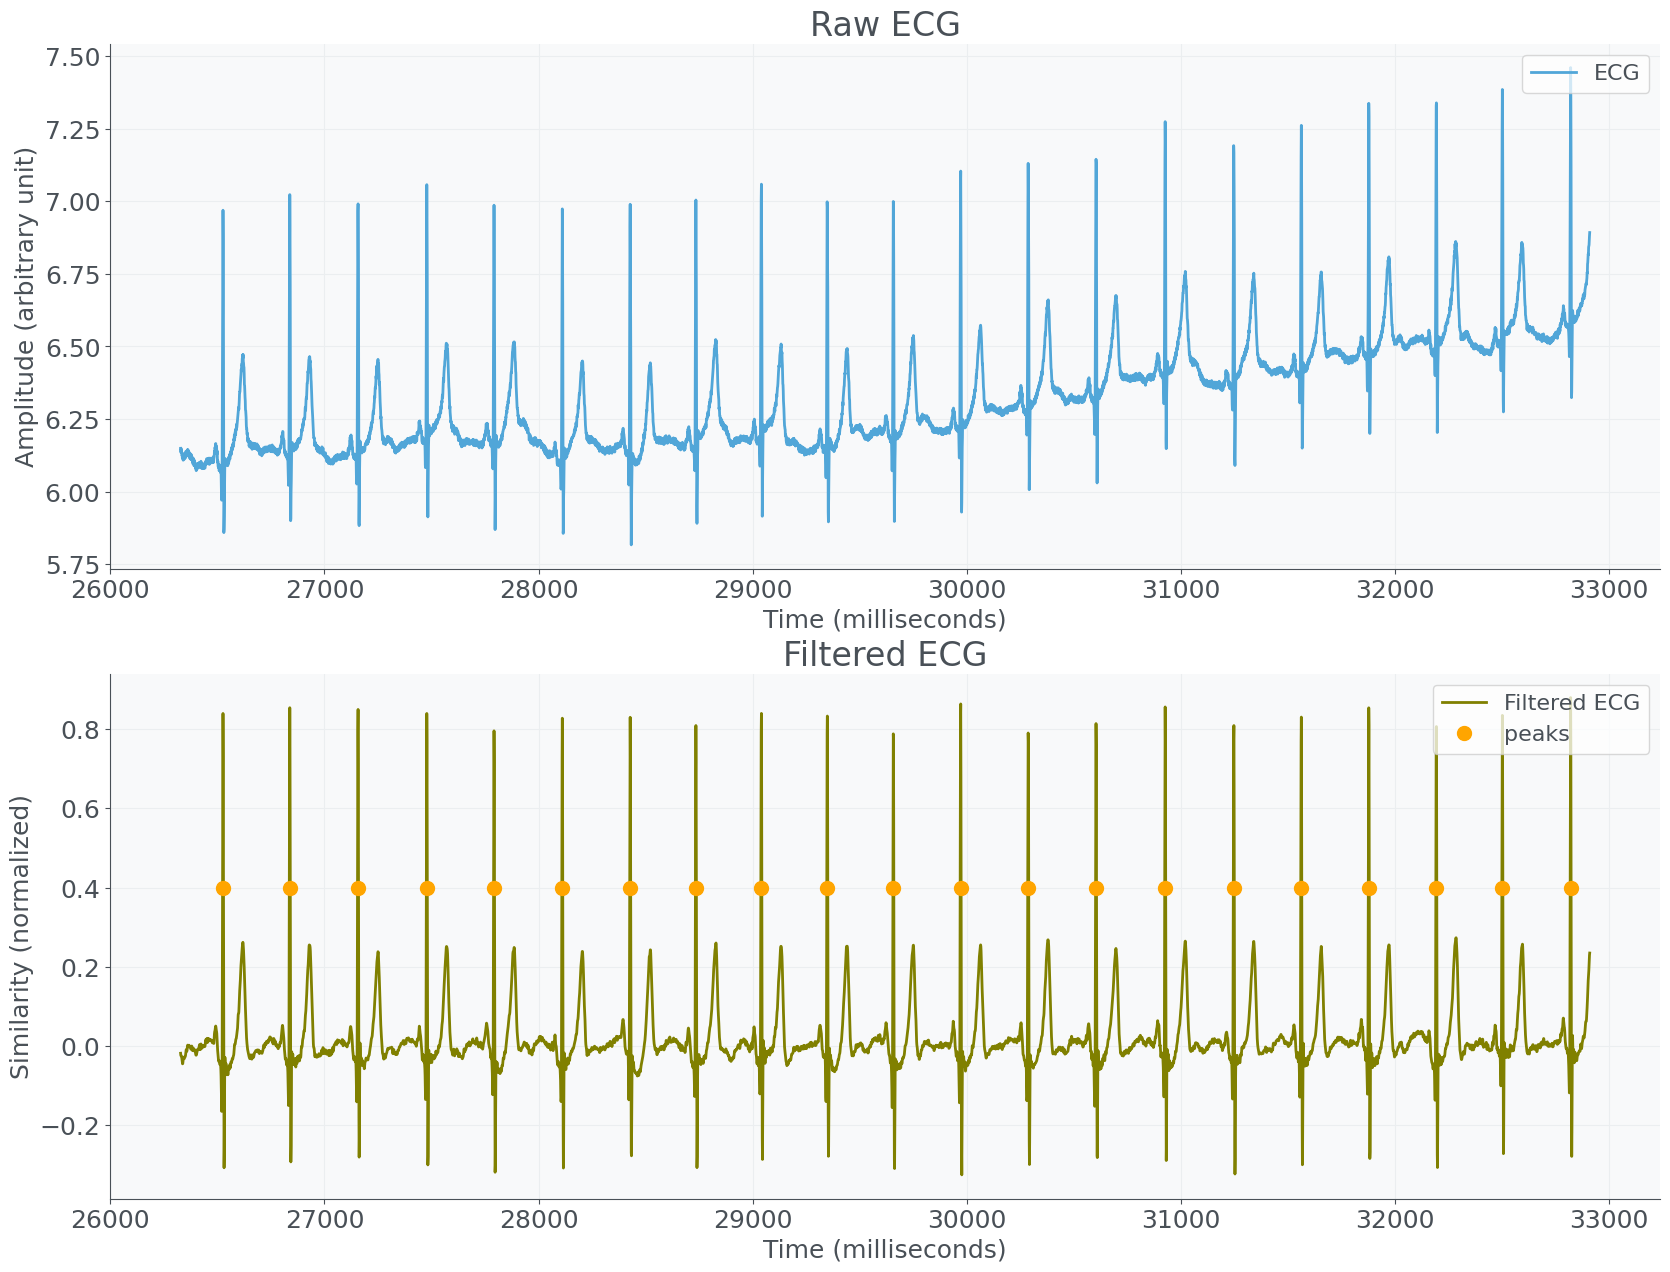

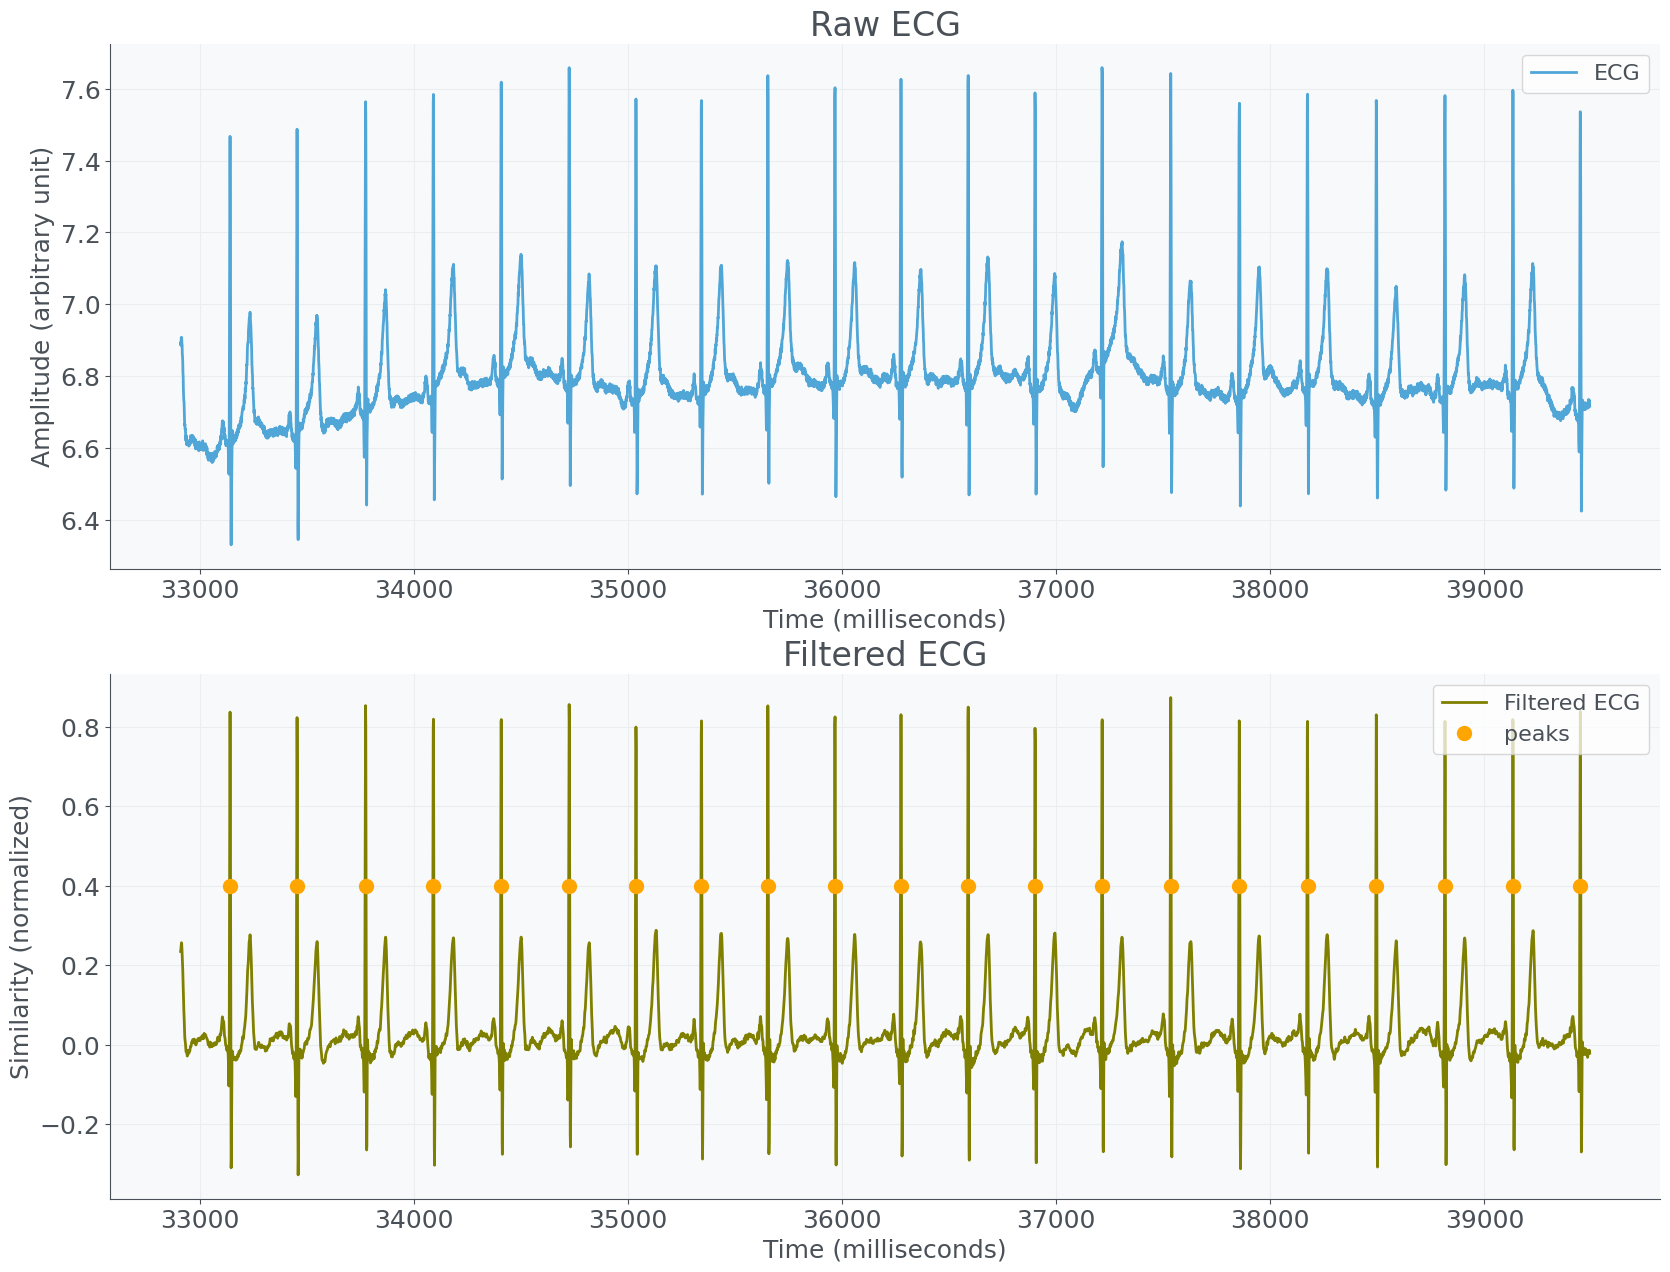

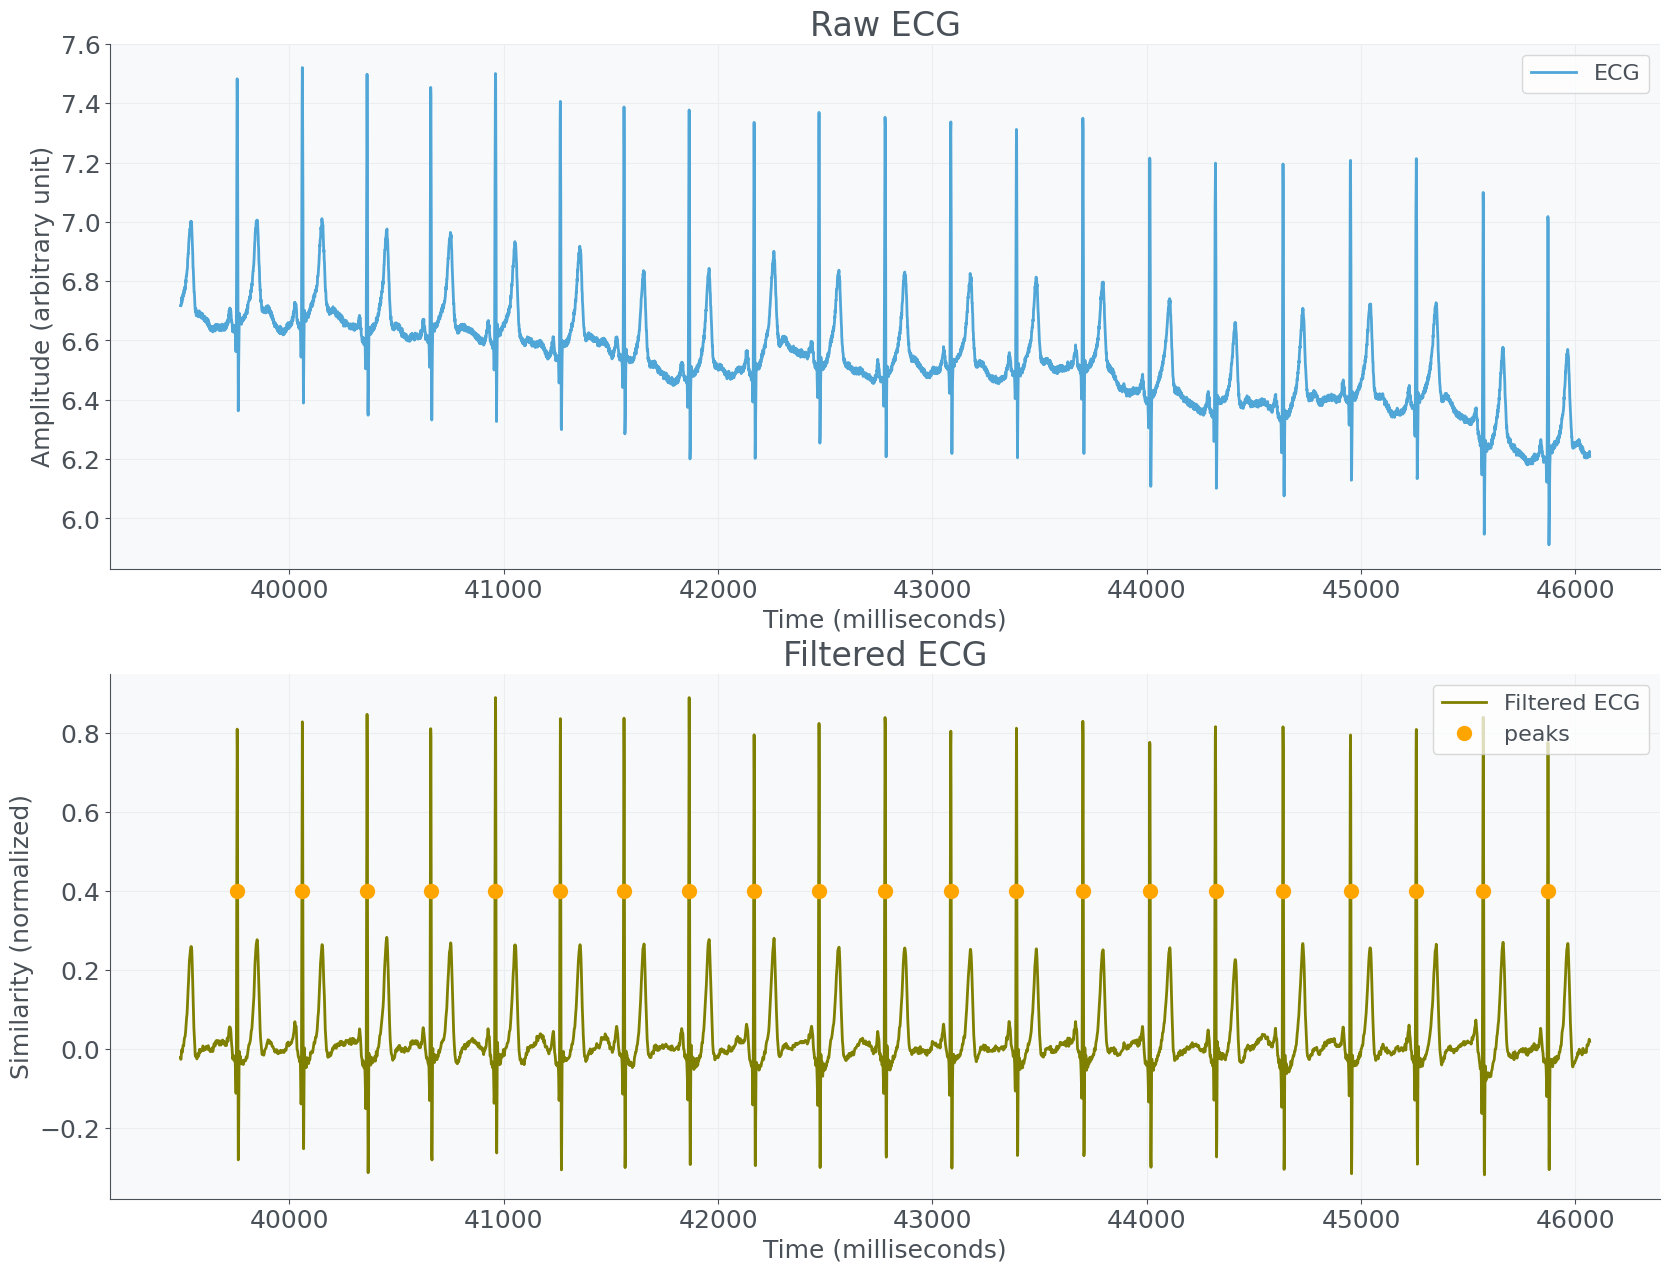

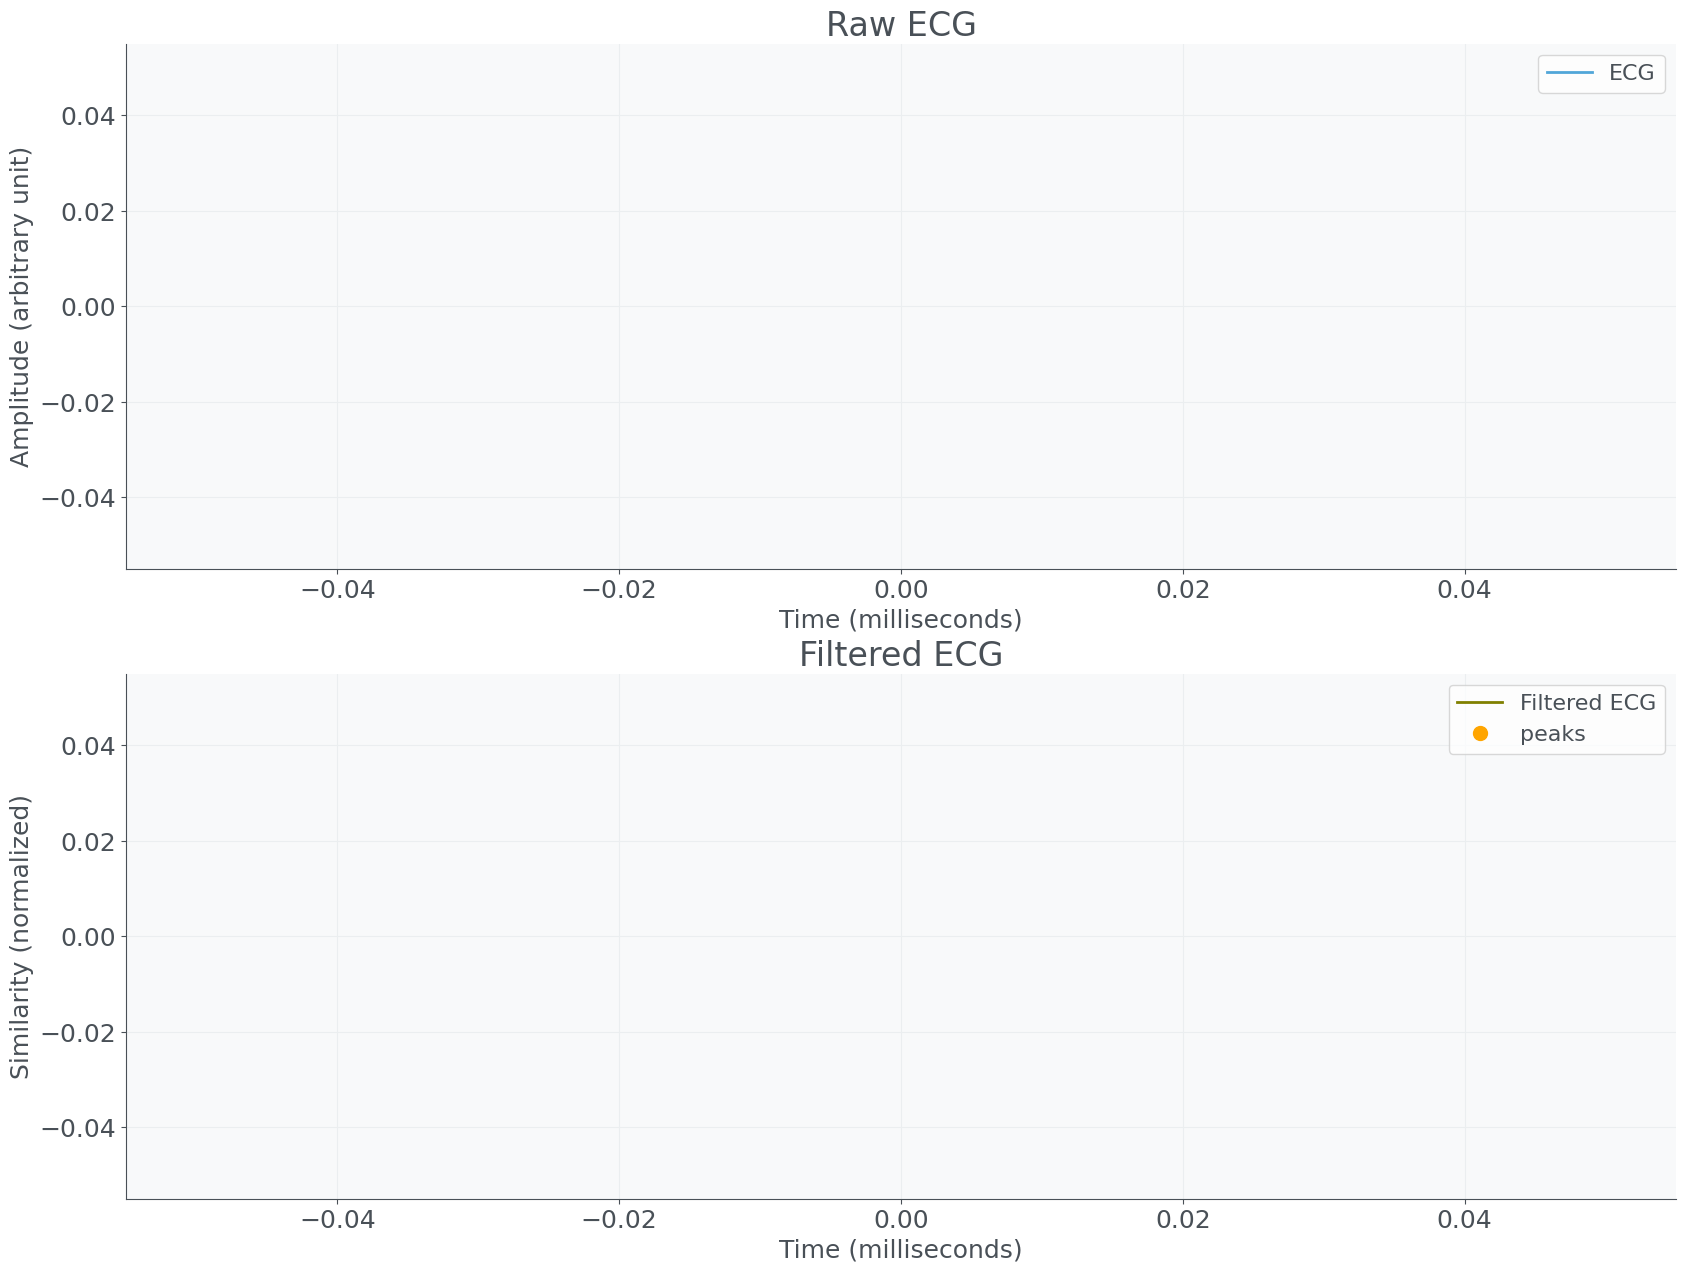

In [17]:
sampling_freq = 256
ecg_array = sliced_ecg_df["heartrate"].values
out = ecg.ecg(signal=ecg_array, sampling_rate=sampling_freq, show=False,interactive=False)
sliced_ecg_df["filtered"] = out["filtered"]
r_peaks_ind = out["rpeaks"]
rr_diff_msec= from_rr_ind_2_msec(r_peaks_ind)
#r_peaks = detect_peaks(sliced_ecg_df["filtered"].values, threshold=0.3, qrs_filter=None)
#plot_ecg_wf(sliced_ecg_df, r_peaks, nr_plots)
rr_corrected_msec=remove_outliers_rri(rr_diff_msec)

###---------------------------------------------------------
ecg_df= pd.DataFrame()
ecg_df["raw_ecg"] = ecg_array
ecg_df["filtered"] = out["filtered"]

nr_plots = 7
offset_min = offset_min_list_new[ind_event_interest][ind_offset_min]
plot_ecg_wf(ecg_df,r_peaks_ind,offset_min, nr_plots=nr_plots)

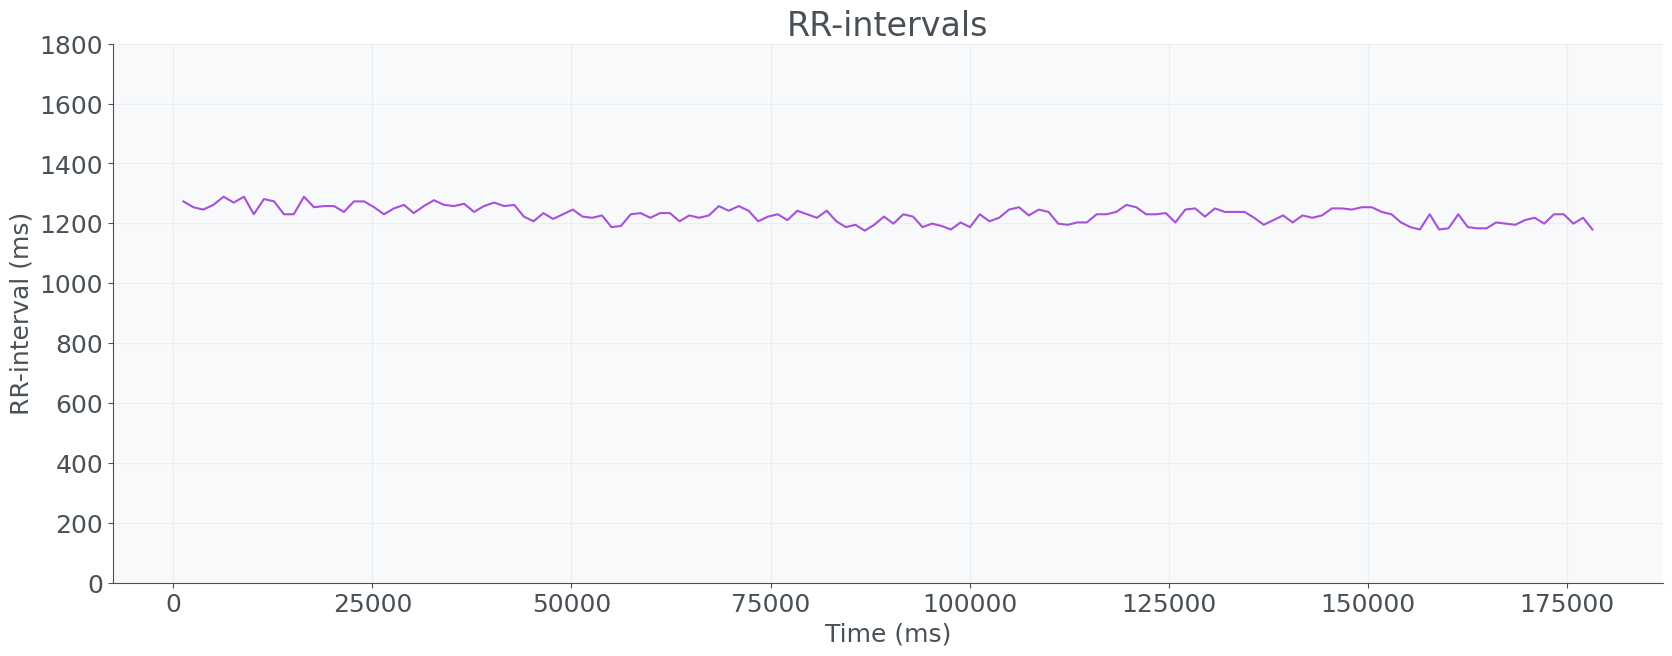

In [19]:
plot_rr_intervals(rr_corrected_msec)

<Figure size 640x480 with 0 Axes>

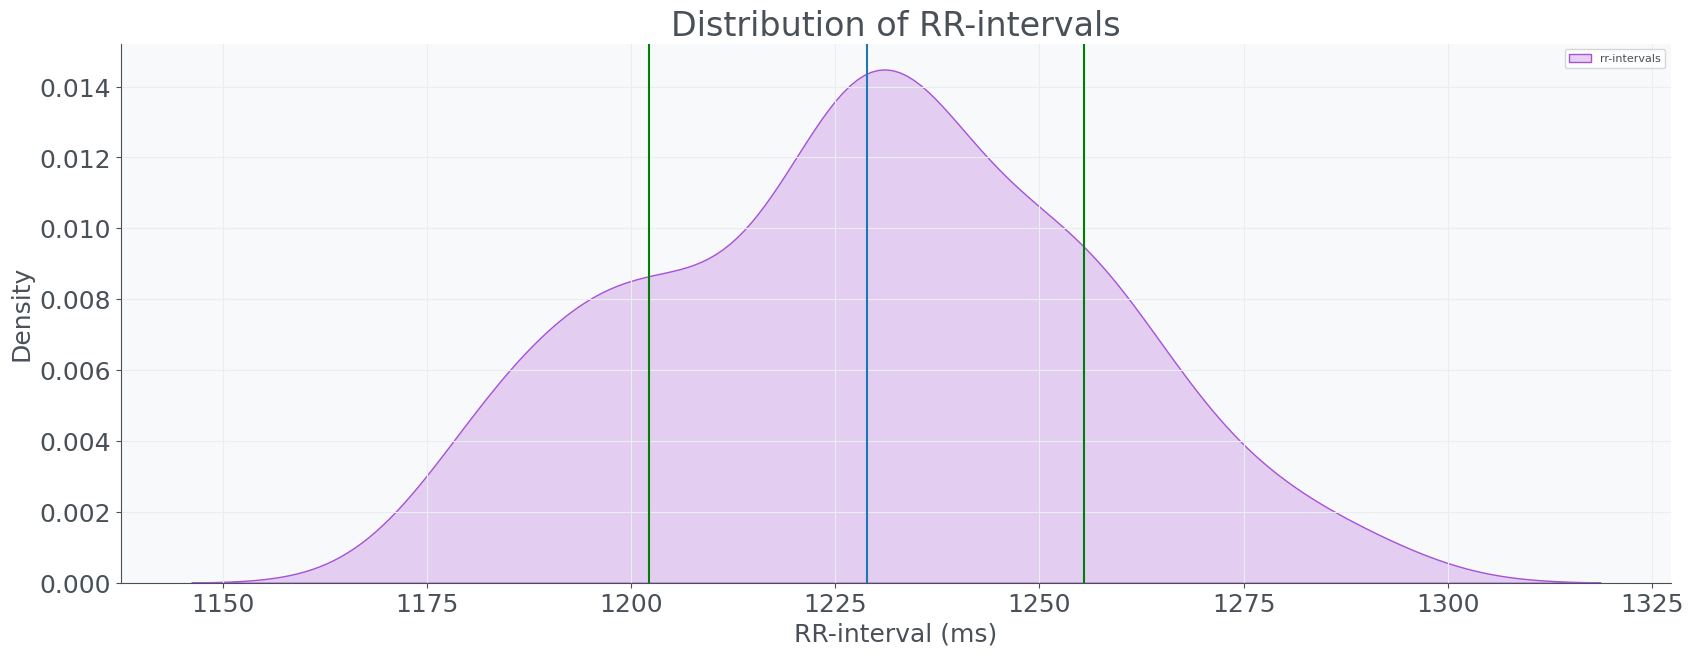

In [20]:
plot_rr_inerval_distribution(rr_corrected_msec)

In [21]:
time_domain_features = timedomain(rr_corrected_msec)

In [22]:
time_domain_features

{'Mean RR (ms)': 1228.8254310344828,
 'STD RR/SDNN (ms)': 26.6150159325534,
 'Mean HR (beats/min)': 48.85003452880612,
 'STD HR (beats/min)': 1.0585634440668057,
 'Min HR (beats/min)': 46.54545454545455,
 'Max HR (beats/min)': 51.029900332225914,
 'RMSSD (ms)': 22.6839210809692,
 'NNxx': 5,
 'pNNxx (%)': 3.4482758620689653}

## Poincare plot - non-linear analysis

SD1: 16.033 ms
SD2: 33.744 ms


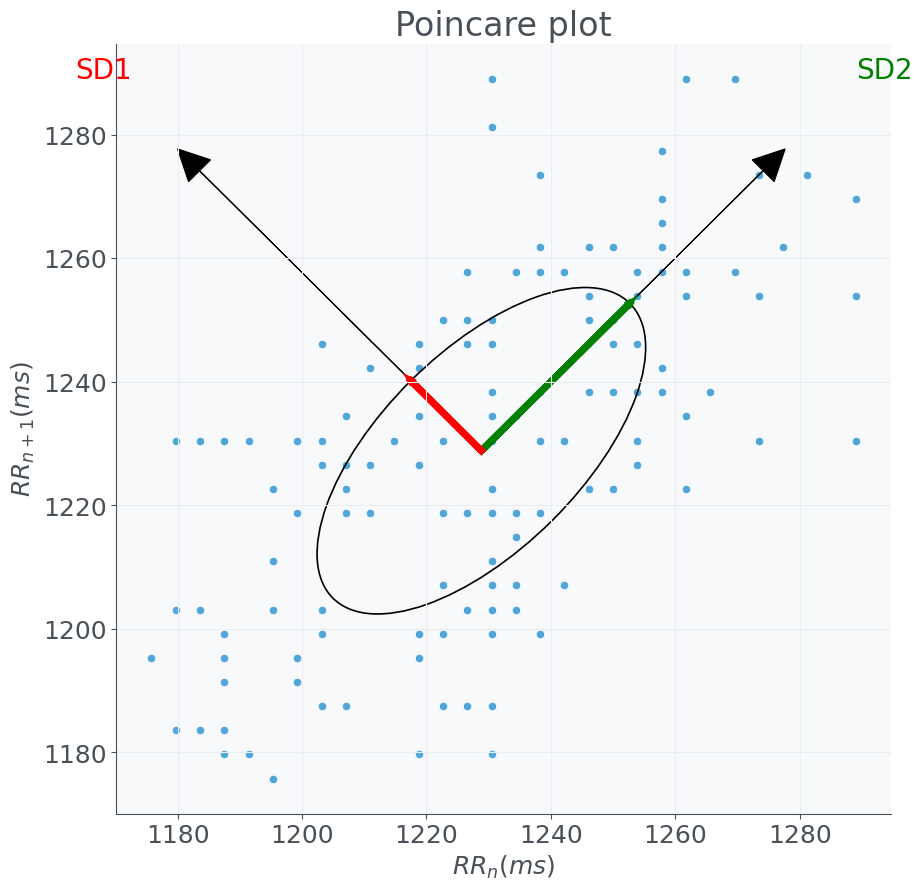

In [23]:
sd1, sd2 = plot_poincare(rr_corrected_msec)
print("SD1: %.3f ms" % sd1)
print("SD2: %.3f ms" % sd2)

### Frequency Domain Analysis

In [24]:
rr_msec_interpolated = from_rr_to_rr_interpolated(rr_corrected_msec)

ValueError: x and y must have same first dimension, but have shapes (590,) and (506,)

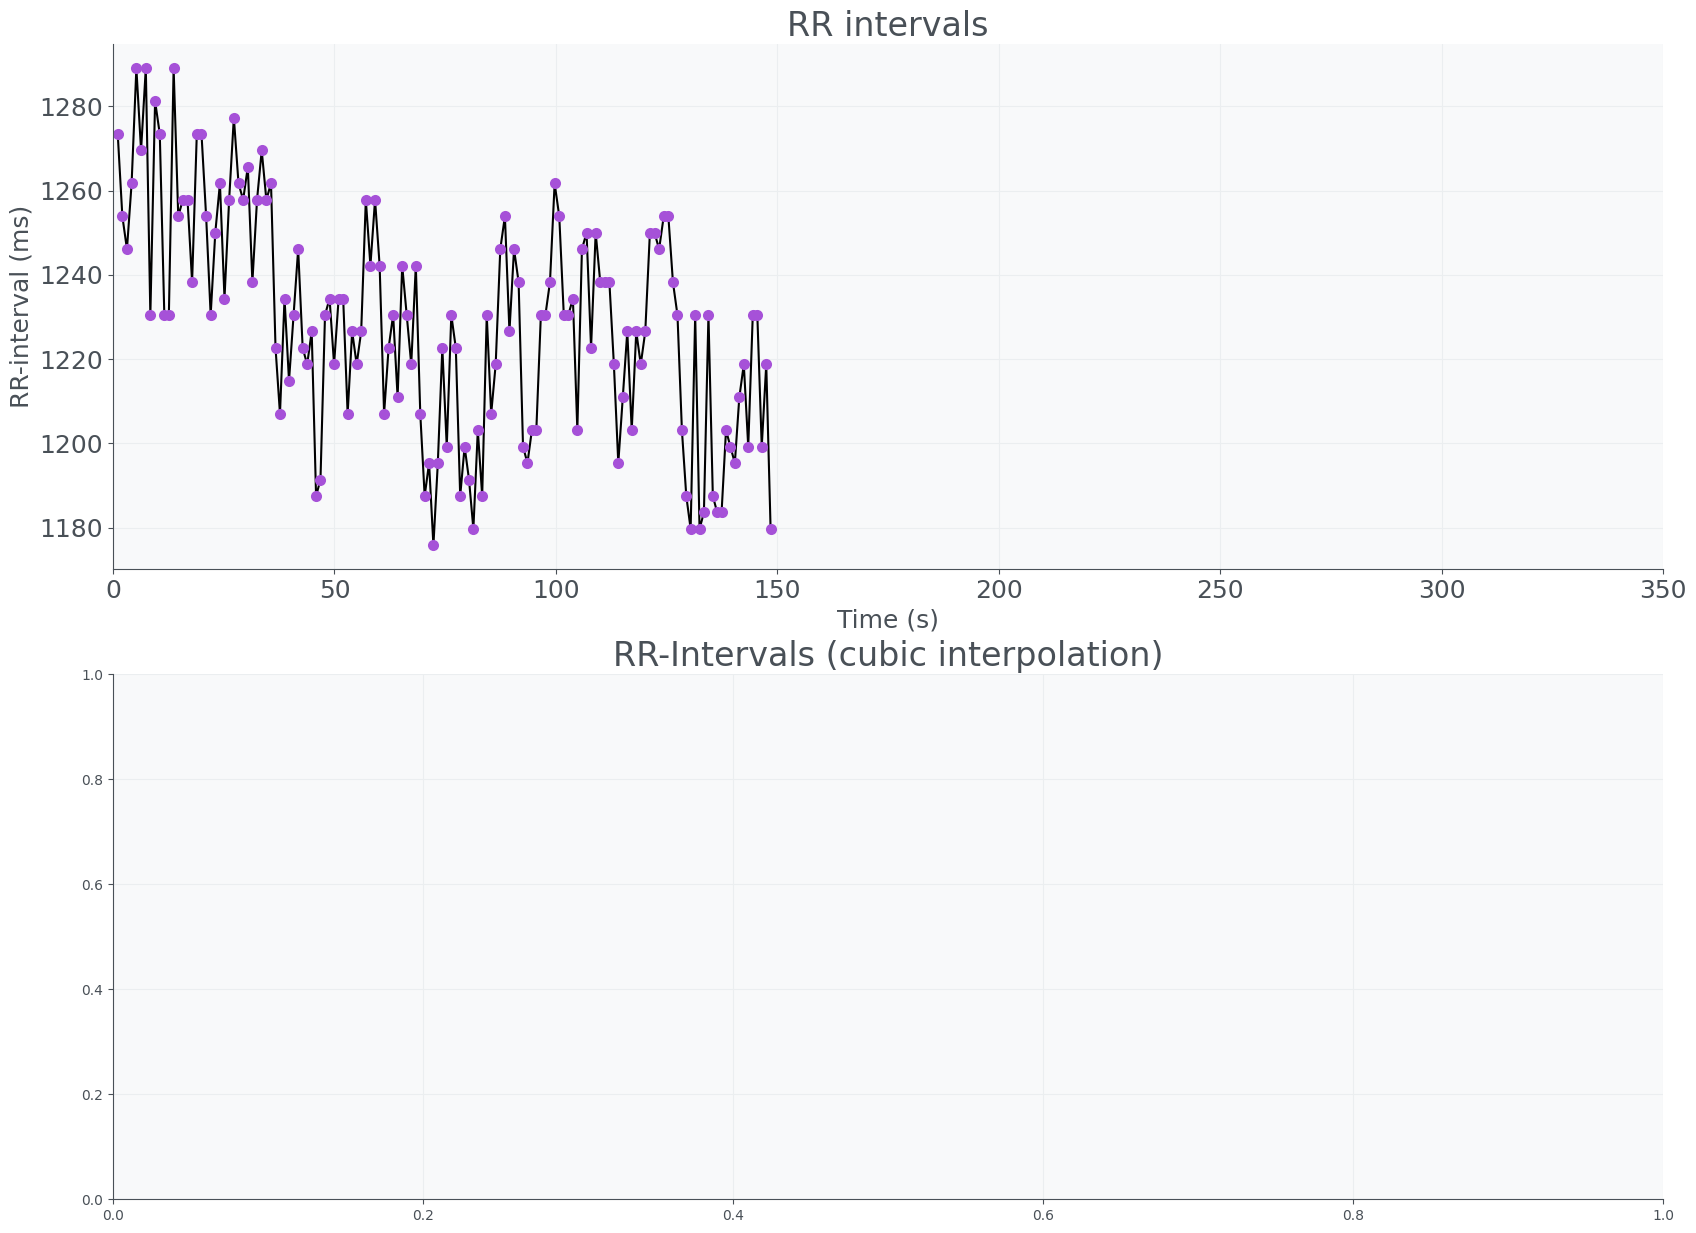

In [25]:
plot_rr_rr_interpolated_intervals(rr_corrected_msec, rr_msec_interpolated)

In [26]:
print("Frequency domain metrics:")
results, fxx, pxx = frequency_domain_rr(rr_msec_interpolated)

for k, v in results.items():
    print("- %s: %.2f" % (k, v))


Frequency domain metrics:
- Power VLF (ms2): 155.36
- Power LF (ms2): 123.55
- Power HF (ms2): 77.09
- Power Total (ms2): 356.00
- LF/HF: 1.60
- Peak VLF (Hz): 0.02
- Peak LF (Hz): 0.05
- Peak HF (Hz): 0.16
- Fraction LF (nu): 61.58
- Fraction HF (nu): 38.42


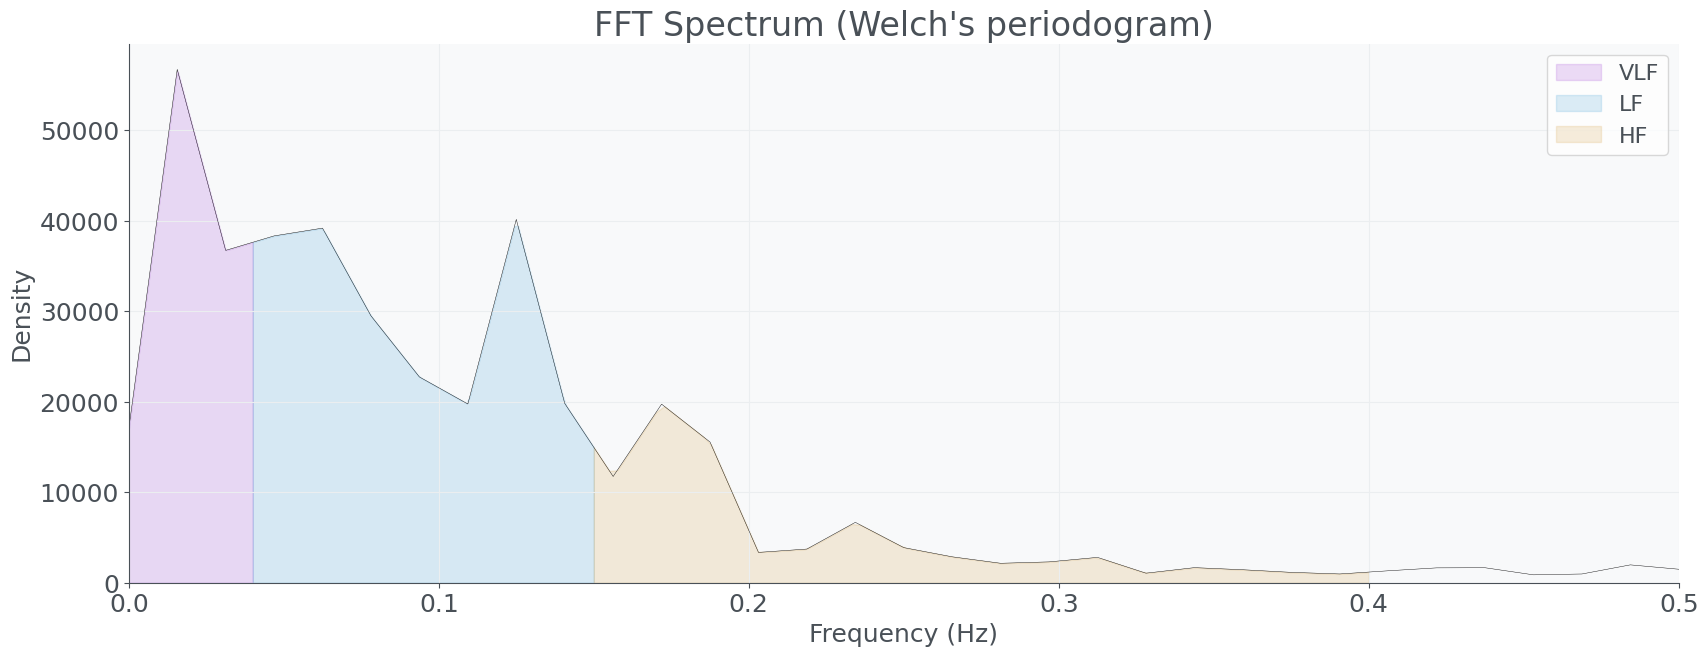

In [42]:
plot_fft_spectrum(rr_msec_interpolated)